# EDA - Explanatory Data Analysis - on Satellite Imagery

Hyperspectral Image(HSI) data often contains hundreds of spectral bands over the same spatial area which provide valuable information to identify the various materials. In HSI, each pixel can be regarded as a high dimensional vector whose entries correspond to the spectral reflectance from visible to infrared.

There are 14 datatsets available in EarthPy package.

In [84]:
import earthpy as ep
import earthpy.spatial as es
import earthpy.plot as etp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from glob import glob

ep.data.path = '.'
# sepcify the dataset name to download 
data = ep.data.get_data('vignette-landsat')

In [29]:
data

'./vignette-landsat/.'

In [31]:
landsat_path = glob('vignette-landsat/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band*_crop.tif')
landsat_path.sort()

The bands are selected and stacked using the 'stack' method from the spatial module of EarthPy. 

In [35]:
# stacking bands
arr_st, meta = es.stack(landsat_path, nodata=-9999)
# print metadata
for i, j in meta.items():
    print("%10s : %s"%(i, str(j)))

    driver : GTiff
     dtype : int16
    nodata : -9999.0
     width : 2158
    height : 1941
     count : 7
       crs : EPSG:32613
 transform : | 30.00, 0.00, 449085.00|
| 0.00,-30.00, 4434855.00|
| 0.00, 0.00, 1.00|
blockysize : 1
     tiled : False
interleave : band


The dataset has the shape (2158, 1941), 7 bands.

### Plot Bands

We plot the bands using the inbuilt method 'plot_bands' form the earthpy package.
The plot_bands method takes the stack of the bands and plots along with custom titles which can be done by passing unique titles for each image as a list of titles using the title= parameter.

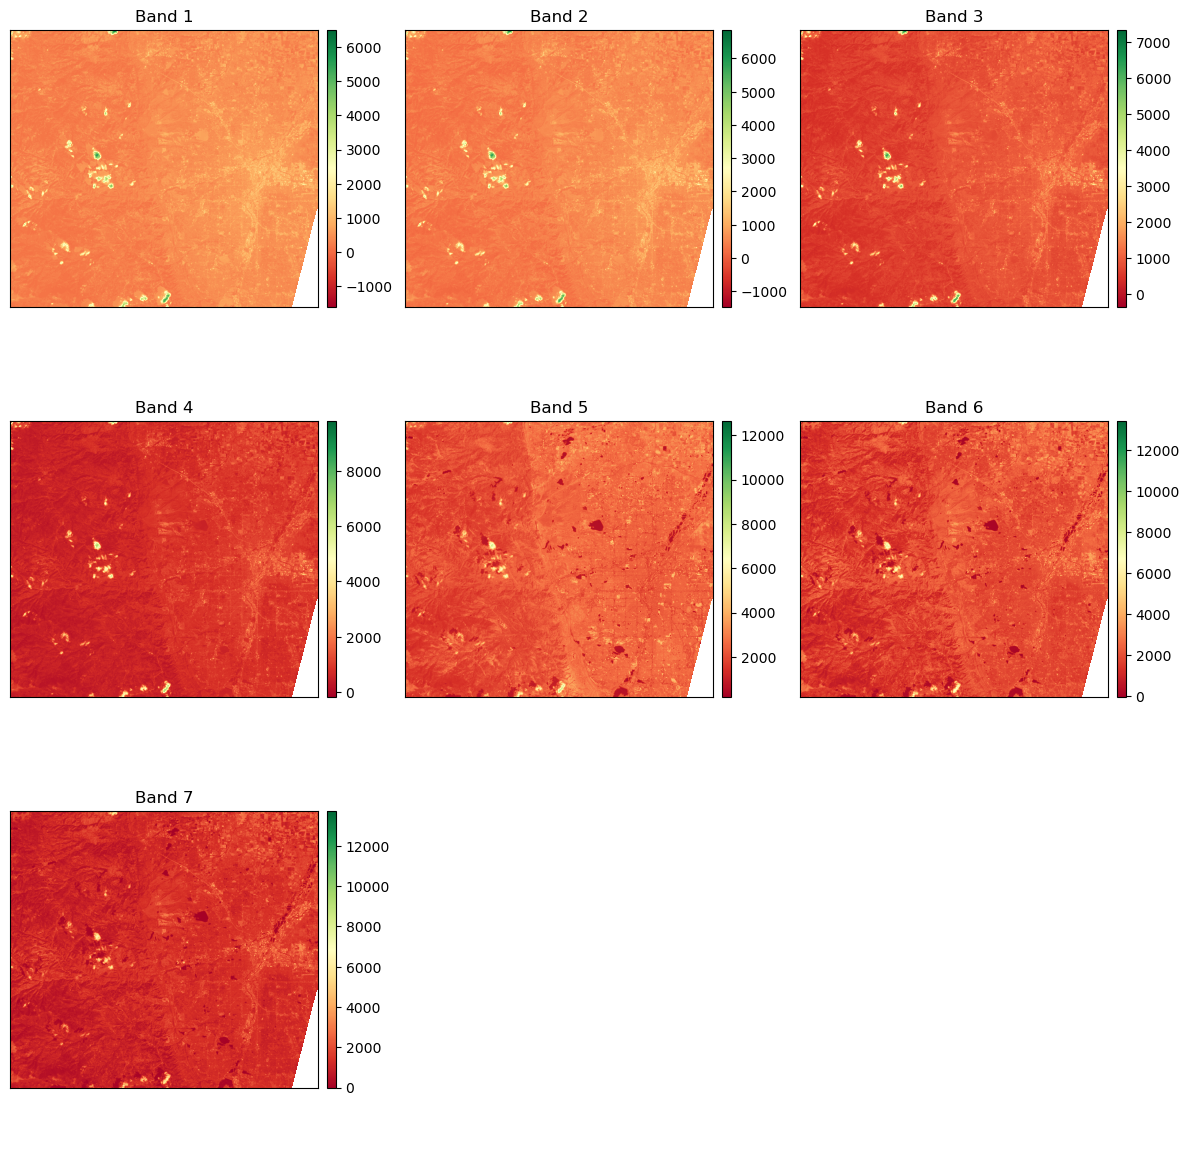

In [43]:
im = etp.plot_bands(arr_st, cmap='RdYlGn', figsize=(12, 12))
plt.show()

### RGB composite image

These hyperspectral images have multiple numbers of bands that contain the data ranging from visible to infrared. So it is hard to visualize the data for humans. So the creating an RGB Composite Image makes it easier to understand the data effectively.
To plot RGB composite images, we will plot the red, green, and blue bands, which are bands 4, 3, and 2, respectively, in the image stack we created from the Landsat8 data. Python uses a zero-based index system, so we need to subtract a value of 1 from each index. Therefore, the index for the red band is 3, green is 2, and blue is 1. Let’s see the code to plot the RGB composite image.

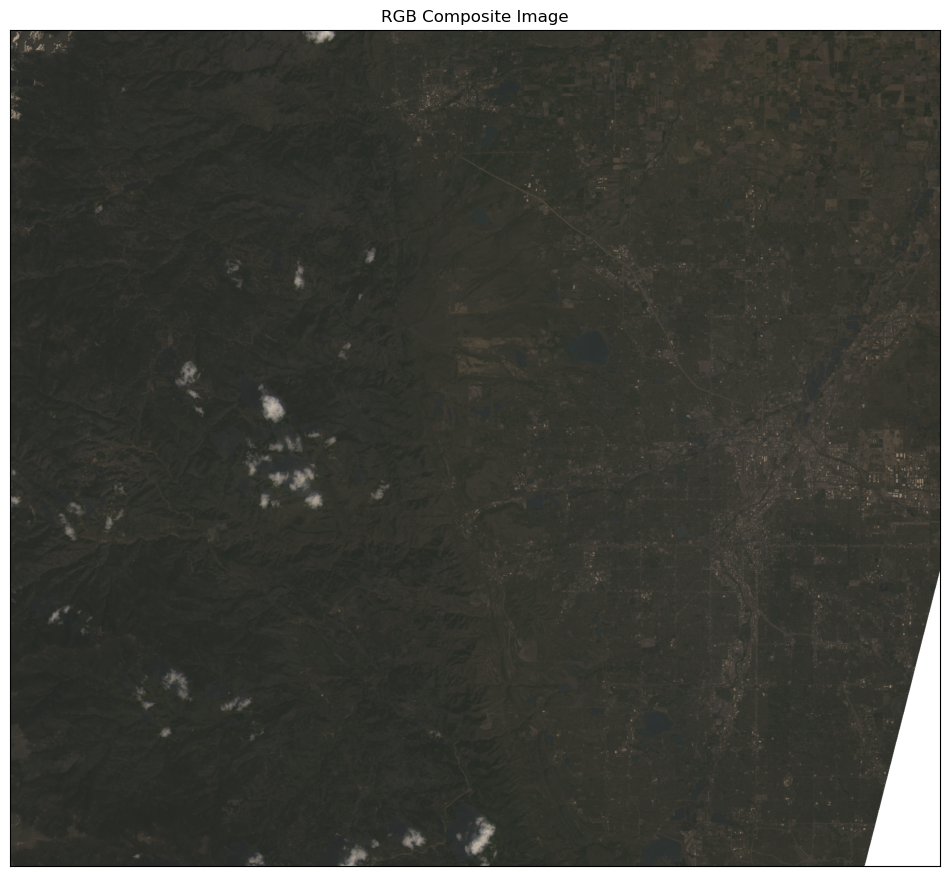

In [47]:
rgb = etp.plot_rgb(arr_st,
                   rgb=(3, 2, 1),
                   figsize=(12, 12),
                   title='RGB Composite Image')

### Stretching the Composite Image

The Composite images that we created can sometimes be dark if the pixel brightness values are skewed toward the value of zero. This type of problem can be solved by stretching the pixel brightness values in an image using the argument stretch=True to extend the values to the full 0-255 range of potential values to increase the visual contrast of the image. Also, the str_clip argument allows you to specify how much of the tails of the data that you want to clip off. The larger the number, the more the data will be stretched or brightened.

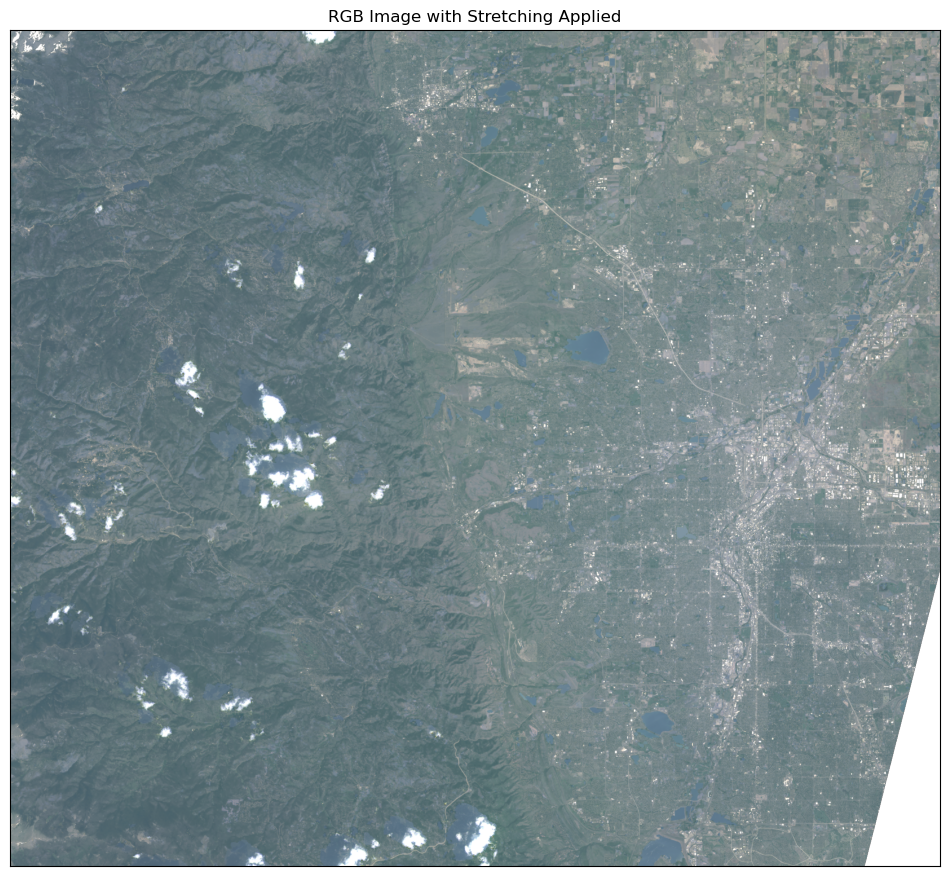

In [55]:
etp.plot_rgb(arr_st,
             rgb=(3, 2, 1),
             stretch=True,
             str_clip=0.5,
             figsize=(12, 12),
             title='RGB Image with Stretching Applied')
plt.show()

### Plotting Spectra

Plotting spectra helps us to understand the nature of the pixels.

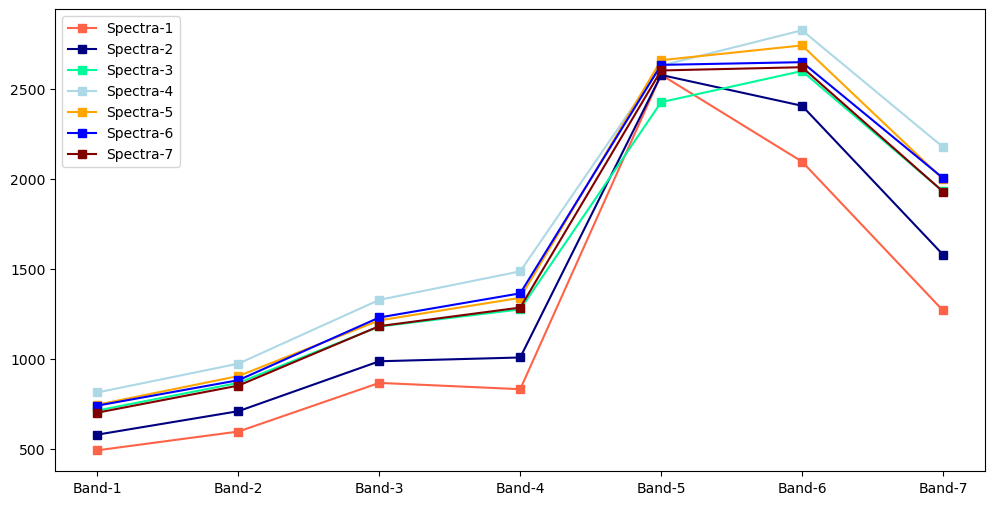

In [70]:
colours = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue', 'maroon']

plt.figure(figsize=(12, 6))
for i, c in enumerate(colours):
    plt.plot(np.asarray(arr_st[:, 0, i]), '-s', color=c, label=f'Spectra-{i+1}')
plt.xticks(range(7), [f'Band-{i}' for i in range(1, 8)])
plt.legend()
plt.show()

### Histograms
Visualizing the bands of the hyperspectral image dataset helps us to understand the distribution of the values of the bands. The hist method from the ‘eathpy.plot’ does the work by plotting the histograms for the bands of the dataset/stack that we created previously. We can also modify the column size, titles, colors of the individual histograms.

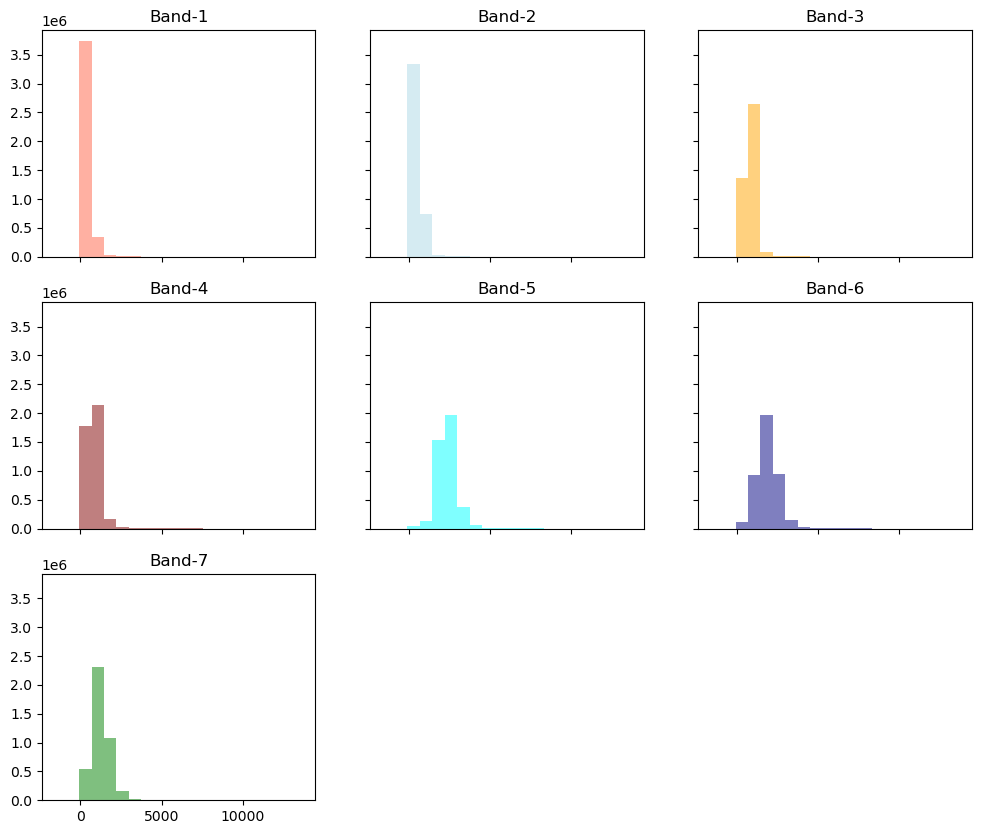

In [73]:
colours = ['tomato', 'lightblue', 'orange', 'maroon', 'cyan', 'navy', 'green']
etp.hist(arr_st, colors=colours, title=[f'Band-{i}' for i in range(1, 8)], cols=3, alpha=0.5, figsize=(12, 10))
plt.show()

### Normalized Difference Vegetation Index (NDVI)

To determine the density of green on a patch of land, researchers must observe the distinct colors (wavelengths) of visible(VIS) and near-infrared (NIR)sunlight reflected by the plants. The Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared which vegetation strongly reflects and red light (which vegetation absorbs). NDVI always ranges from -1 to +1.

NDVI = (NIR — VIS)/(NIR + VIS)

For example, when you have negative values, it’s highly likely that it’s water. On the other hand, if you have an NDVI value close to +1, there’s a high possibility that it’s dense green leaves. But when NDVI is close to zero, there aren’t green leaves and it could even be an urbanized area.

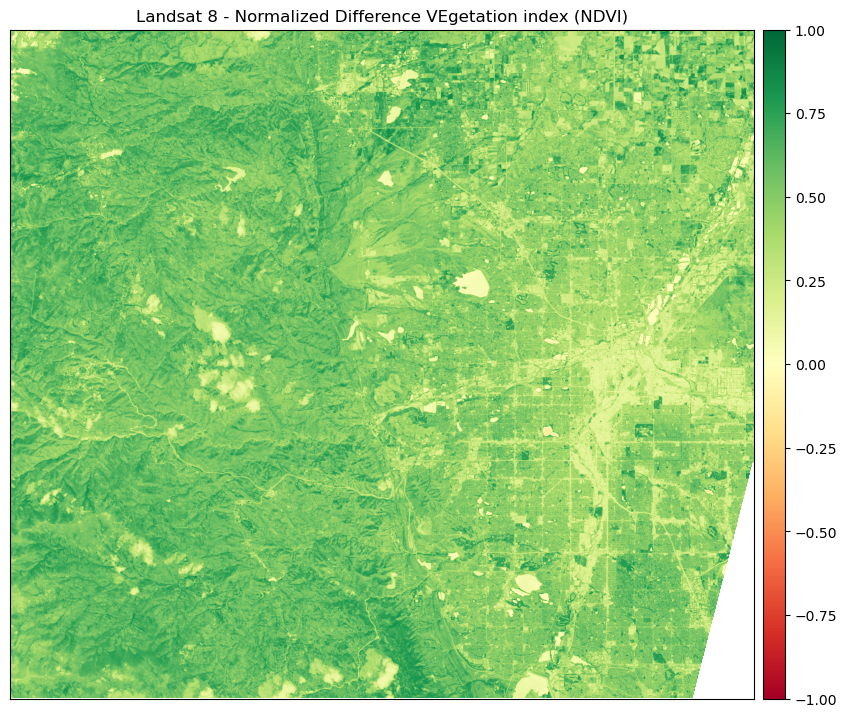

In [76]:
# Landsat 8 red band is band 4 at [3]
# Landsat 8 near-infrared band is band 5 at [4]

ndvi = es.normalized_diff(arr_st[4], arr_st[3])
titles = ["Landsat 8 - Normalized Difference Vegetation index (NDVI)"]
etp.plot_bands(ndvi, cmap='RdYlGn', cols=1, title=titles, vmin=-1, vmax=1, figsize=(10, 10))
plt.show()

### Classiffication of NDVI

The Normalized Difference Vegetation Index(NDVI) results are categorized into useful classes based on the Hyperspectral Image data. The values under 0 will be classified together as no vegetation. Additional classes will be created for the bare area and low, moderate, and high vegetation areas.

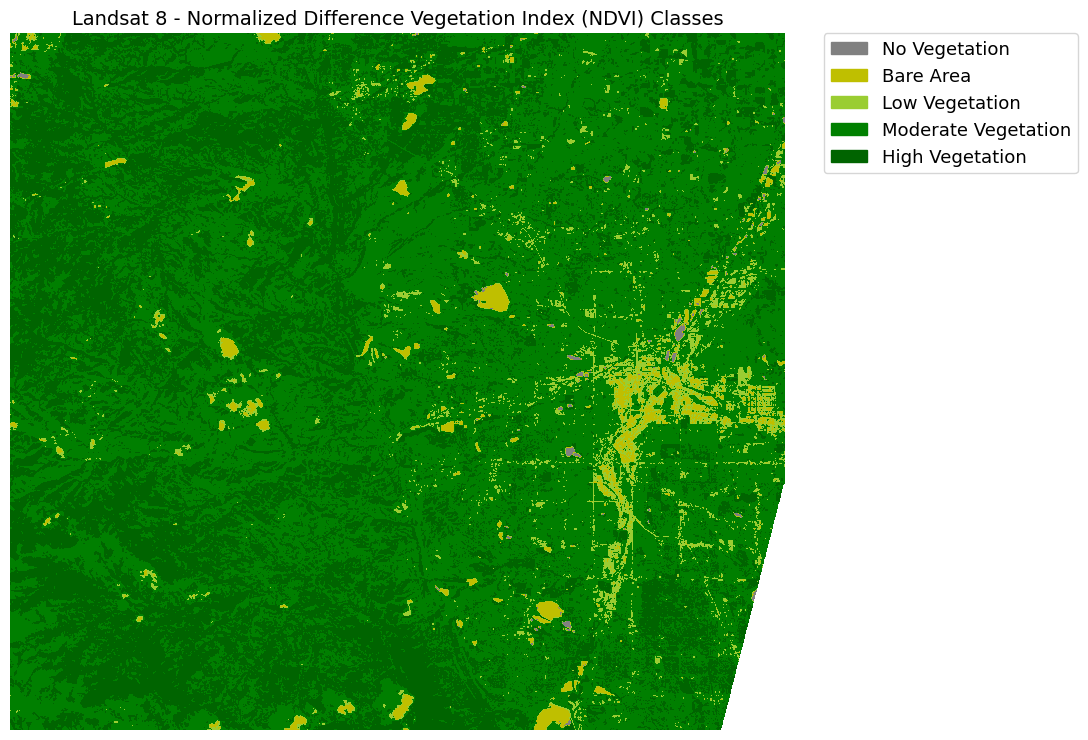

In [92]:
# create clases and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.15, 0.23, 0.6, np.inf]
ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

# apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(np.ma.getmask(ndvi), ndvi_landsat_class)
np.unique(ndvi_landsat_class)

nbr_colors = ['gray', 'y', 'yellowgreen', 'g', 'darkgreen']
nbr_cmap = ListedColormap(nbr_colors)

# define class names
ndvi_cat_names = [
    'No Vegetation',
    'Bare Area',
    'Low Vegetation',
    'Moderate Vegetation',
    'High Vegetation'
]

# get list of classes
classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()

# the mask returns a value of none in the classes
classes = classes[0:5]

# plot the data
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)
etp.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)

ax.set_title(
    "Landsat 8 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,)
ax.set_axis_off()

# auto 